In [1]:
import os
from collections import Counter
HOME = os.getcwd()
HOME = HOME[0:HOME.find("notebooks")]
DATA_FOLDER = HOME + "data\\"
DATA_FOLDER

'c:\\Users\\yashy\\Programming\\drowning-detection-system\\data\\'

## **1. Class Distribution**

In [2]:
# Paths to the labels directories
train_labels_dir = DATA_FOLDER + "train\\labels"
val_labels_dir = DATA_FOLDER + "valid\\labels"
test_labels_dir = DATA_FOLDER + "test\\labels"

In [3]:
# Function to count classes
def count_classes(labels_dir):
    class_counts = Counter()
    for label_file in os.listdir(labels_dir):
        with open(os.path.join(labels_dir, label_file), 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                class_counts[class_id] += 1
    return class_counts

In [4]:
# Count class occurrences in each set
train_class_counts = count_classes(train_labels_dir)
val_class_counts = count_classes(val_labels_dir)
test_class_counts = count_classes(test_labels_dir)

In [5]:
# Display results
class_names = ["Active Drowning", "Possible Passive Drowner", "Swimming"]

print("Class Distribution in Training Set:")
for class_id, count in train_class_counts.items():
    print(f"{class_names[class_id]}: {count} instances")

print("\nClass Distribution in Validation Set:")
for class_id, count in val_class_counts.items():
    print(f"{class_names[class_id]}: {count} instances")

print("\nClass Distribution in Test Set:")
for class_id, count in test_class_counts.items():
    print(f"{class_names[class_id]}: {count} instances")

Class Distribution in Training Set:
Possible Passive Drowner: 279 instances
Swimming: 540 instances
Active Drowning: 486 instances

Class Distribution in Validation Set:
Active Drowning: 111 instances
Possible Passive Drowner: 25 instances
Swimming: 68 instances

Class Distribution in Test Set:
Active Drowning: 101 instances
Swimming: 37 instances
Possible Passive Drowner: 43 instances


## **2. Image Quality and Dimensions**

In [6]:
import cv2
import matplotlib.pyplot as plt

In [7]:
# Paths to the images directories
train_images_dir = DATA_FOLDER + "train\\images"
val_images_dir = DATA_FOLDER + "valid\\images"
test_images_dir = DATA_FOLDER + "test\\images"

In [8]:
# Function to collect image resolutions
def get_image_resolutions(images_dir):
    resolutions = []
    for image_file in os.listdir(images_dir):
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        if image is not None:
            height, width = image.shape[:2]
            resolutions.append((width, height))
    return resolutions

In [9]:
# Get image resolutions for each set
train_resolutions = get_image_resolutions(train_images_dir)
val_resolutions = get_image_resolutions(val_images_dir)
test_resolutions = get_image_resolutions(test_images_dir)

In [10]:
# Plot resolutions
def plot_resolutions(resolutions, title):
    widths, heights = zip(*resolutions)
    plt.scatter(widths, heights)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title(title)
    plt.show()

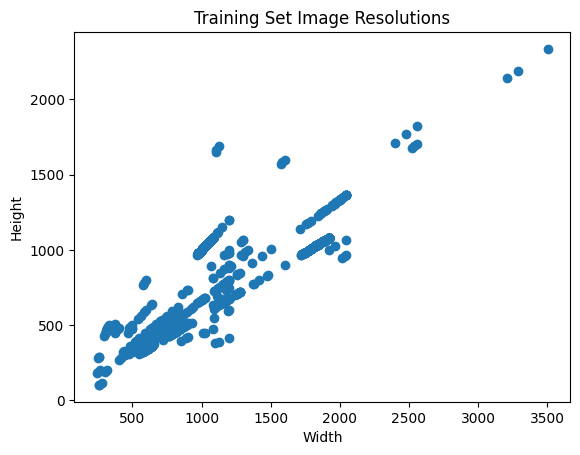

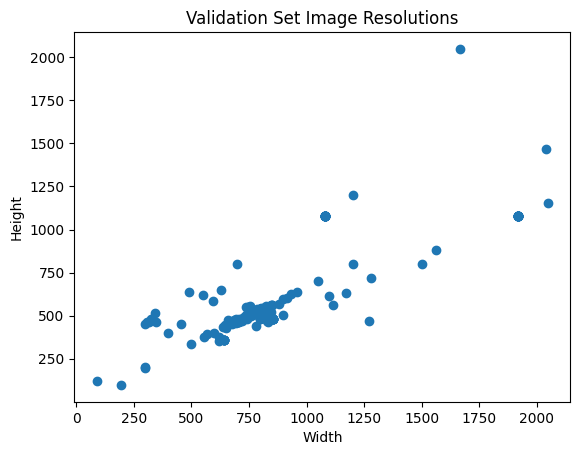

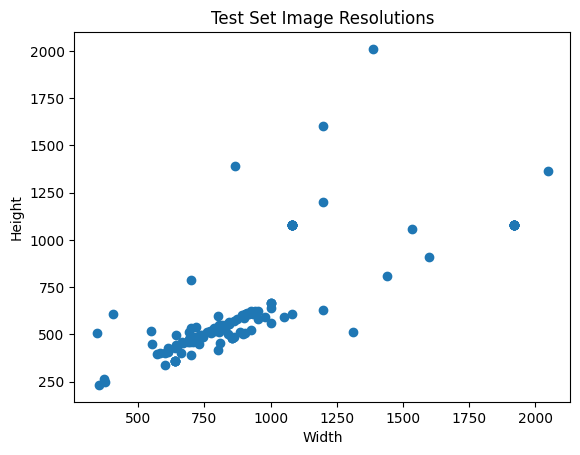

In [11]:
plot_resolutions(train_resolutions, 'Training Set Image Resolutions')
plot_resolutions(val_resolutions, 'Validation Set Image Resolutions')
plot_resolutions(test_resolutions, 'Test Set Image Resolutions')

## **3. Bounding Box Statistics**

In [12]:
# Function to extract bounding box dimensions from YOLO format
def get_bbox_stats(labels_dir, image_dir):
    bbox_widths = []
    bbox_heights = []
    aspect_ratios = []

    for label_file in os.listdir(labels_dir):
        with open(os.path.join(labels_dir, label_file), 'r') as f:
            for line in f:
                class_id, x_center, y_center, bbox_width, bbox_height = map(
                    float, line.split())

                # Convert from relative to absolute pixel values
                # Assuming images are in JPG format
                image_file = label_file.replace('.txt', '.jpg')
                image_path = os.path.join(image_dir, image_file)
                image = cv2.imread(image_path)
                if image is not None:
                    height, width = image.shape[:2]
                    abs_width = bbox_width * width
                    abs_height = bbox_height * height

                    bbox_widths.append(abs_width)
                    bbox_heights.append(abs_height)
                    aspect_ratios.append(abs_width / abs_height)

    return bbox_widths, bbox_heights, aspect_ratios

In [13]:
# Get bounding box stats for the training set
train_bbox_widths, train_bbox_heights, train_aspect_ratios = get_bbox_stats(
    train_labels_dir, train_images_dir)

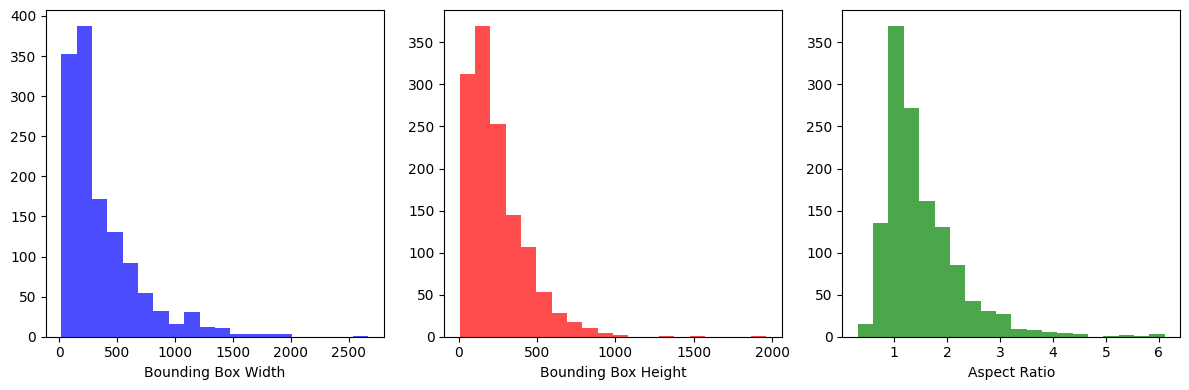

In [14]:
# Plot histograms for bounding box statistics
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(train_bbox_widths, bins=20, color='b', alpha=0.7)
plt.xlabel('Bounding Box Width')

plt.subplot(1, 3, 2)
plt.hist(train_bbox_heights, bins=20, color='r', alpha=0.7)
plt.xlabel('Bounding Box Height')

plt.subplot(1, 3, 3)
plt.hist(train_aspect_ratios, bins=20, color='g', alpha=0.7)
plt.xlabel('Aspect Ratio')

plt.tight_layout()
plt.show()

## **4. Duplicate Images**

In [15]:
import hashlib

# Function to hash images
def hash_image(image_path):
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

In [16]:
def find_duplicates(images_dir):
    image_hashes = {}
    duplicates = []

    for image_file in os.listdir(images_dir):
        image_path = os.path.join(images_dir, image_file)
        img_hash = hash_image(image_path)
        if img_hash in image_hashes:
            duplicates.append(image_file)
        else:
            image_hashes[img_hash] = image_file
    return duplicates

In [17]:
# Check for duplicates in the training set
train_duplicates = find_duplicates(train_images_dir)
test_duplicates = find_duplicates(test_images_dir)
val_duplicates = find_duplicates(val_images_dir)

In [18]:
print(f"Duplicate images in training set: {train_duplicates}")
print(f"Duplicate images in training set: {test_duplicates}")
print(f"Duplicate images in training set: {val_duplicates}")

Duplicate images in training set: []
Duplicate images in training set: []
Duplicate images in training set: []


## **5. Image Color Analysis (Pixel Intensity Distribution)**

In [19]:
import numpy as np

# Function to plot RGB histogram for an image
def plot_rgb_histogram(image_path):
    image = cv2.imread(image_path)
    color = ('b', 'g', 'r')
    plt.figure(figsize=(10, 5))
    for i, col in enumerate(color):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
        plt.xlim([0, 256])
    plt.title(f'RGB Histogram for {image_path}')
    plt.show()

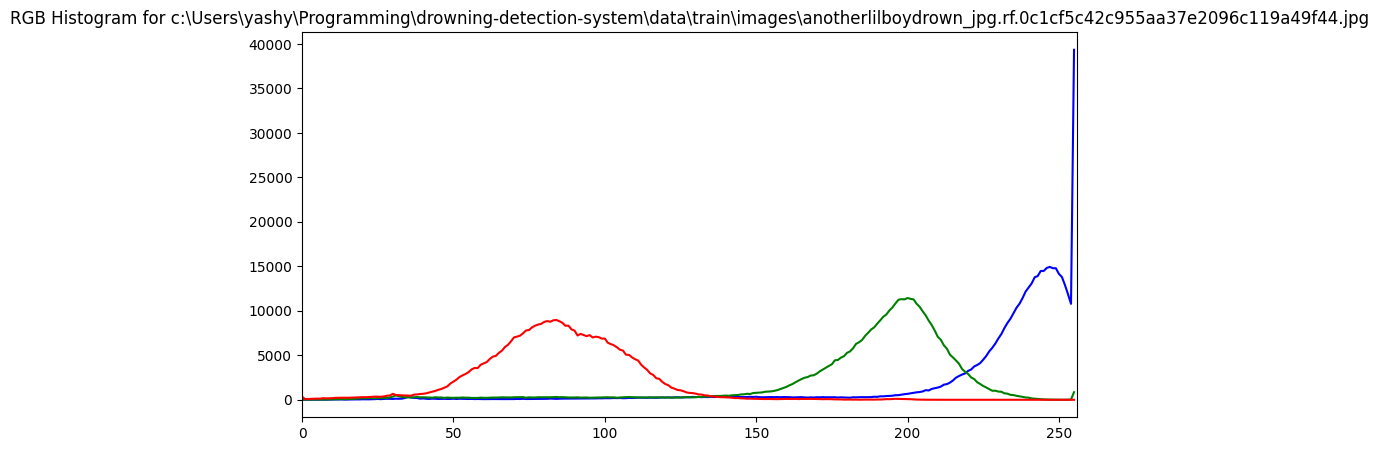

In [20]:
# Test on a sample image
sample_image_path = os.path.join(train_images_dir, os.listdir(train_images_dir)[0])
plot_rgb_histogram(sample_image_path)

## **6. Dataset Balance Across Splits**

In [21]:
import numpy as np

def get_class_balance_across_splits():
    # Normalize class counts across splits
    total_train = sum(train_class_counts.values())
    total_val = sum(val_class_counts.values())
    total_test = sum(test_class_counts.values())

    for class_id in range(3):  # Assuming 3 classes
        train_ratio = train_class_counts[class_id] / total_train if total_train > 0 else 0
        val_ratio = val_class_counts[class_id] / total_val if total_val > 0 else 0
        test_ratio = test_class_counts[class_id] / total_test if total_test > 0 else 0

        print(f"Class: {class_names[class_id]}")
        print(f"Training set: {train_ratio * 100:.2f}%")
        print(f"Validation set: {val_ratio * 100:.2f}%")
        print(f"Test set: {test_ratio * 100:.2f}%")
        print()

get_class_balance_across_splits()


Class: Active Drowning
Training set: 37.24%
Validation set: 54.41%
Test set: 55.80%

Class: Possible Passive Drowner
Training set: 21.38%
Validation set: 12.25%
Test set: 23.76%

Class: Swimming
Training set: 41.38%
Validation set: 33.33%
Test set: 20.44%



## **7. Annotation Overlap and Quality**

In [22]:
def compute_iou(box1, box2):
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])

    intersection_area = max(0, x2_min - x1_max) * max(0, y2_min - y1_max)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area if union_area != 0 else 0

In [23]:
# Function to detect overlapping bounding boxes
def check_overlapping_bboxes(label_file, image_shape):
    with open(label_file, 'r') as f:
        lines = f.readlines()

    bboxes = []
    for line in lines:
        class_id, x_center, y_center, bbox_width, bbox_height = map(float, line.split())
        width, height = image_shape

        x1 = (x_center - bbox_width / 2) * width
        y1 = (y_center - bbox_height / 2) * height
        x2 = (x_center + bbox_width / 2) * width
        y2 = (y_center + bbox_height / 2) * height
        bboxes.append([x1, y1, x2, y2])

    for i in range(len(bboxes)):
        for j in range(i + 1, len(bboxes)):
            iou = compute_iou(bboxes[i], bboxes[j])
            if iou > 0.5:  # Threshold for overlap
                print(f"Overlapping boxes found in {label_file} with IoU: {iou}")

In [24]:
# Define possible image extensions
image_extensions = ['.jpg', '.jpeg', '.png']

# Function to find an image file with the correct extension
def find_image_file(label_file, images_dir):
    base_name = label_file.replace('.txt', '')
    for ext in image_extensions:
        image_file = os.path.join(images_dir, base_name + ext)
        if os.path.exists(image_file):
            return image_file
    return None

In [25]:
#  Example usage
sample_label_file = os.listdir(train_labels_dir)[0]  # Get the first label file
sample_image_file = find_image_file(sample_label_file, train_images_dir)

if sample_image_file is not None:
    image = cv2.imread(sample_image_file)
    if image is not None:
        image_shape = image.shape[:2]
        print(f"Image shape: {image_shape}")
        # Now proceed with bounding box checking
        check_overlapping_bboxes(os.path.join(
            train_labels_dir, sample_label_file), image_shape)
    else:
        print("Error: Unable to read the image.")
else:
    print(
        f"Error: No matching image file found for label file {sample_label_file}")

Image shape: (508, 894)


## **8. Bounding Box Size vs Image Size**

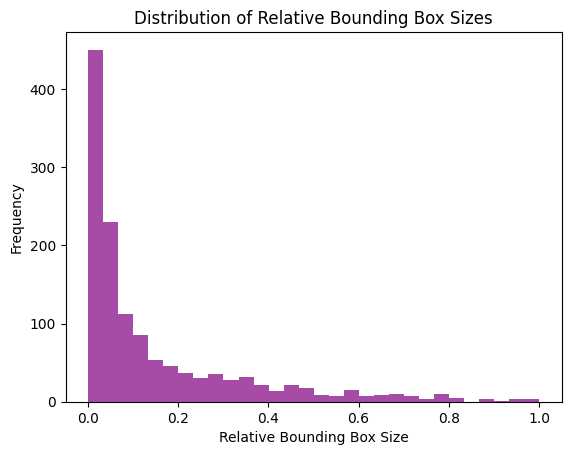

In [26]:
def get_relative_bbox_sizes(labels_dir, images_dir):
    relative_bbox_sizes = []

    for label_file in os.listdir(labels_dir):
        with open(os.path.join(labels_dir, label_file), 'r') as f:
            for line in f:
                _, x_center, y_center, bbox_width, bbox_height = map(float, line.split())

                # Add relative size of bounding box
                relative_bbox_size = bbox_width * bbox_height
                relative_bbox_sizes.append(relative_bbox_size)

    return relative_bbox_sizes

# Analyze relative bounding box sizes in the training set
relative_bbox_sizes = get_relative_bbox_sizes(train_labels_dir, train_images_dir)

plt.hist(relative_bbox_sizes, bins=30, color='purple', alpha=0.7)
plt.xlabel('Relative Bounding Box Size')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Bounding Box Sizes')
plt.show()
